# Clonal Calling Sergeys
Altough the TREX pipeline is update it seems like this notebook does not need to be updated. Some parts become a bit redundant but nothing ruins the analysis as far as I can tell. 

In [1]:
import scanpy as sc
import numpy as np
import muon as mu
import scanpy.external as sce
import pandas as pd
#import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import sys

# Figures aesthetics
sc.set_figure_params(dpi=150)

# Pathes
DATA_PATH = "/home/felix/data/placodal"
HOME_PATH = "/home/felix/projects/placodal"

# Additional functions
exec(open(f"/home/felix/tools/tools_from_sergey/tools_clonal_project.py").read())
sns.set_style("ticks")

/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/anndata/utils.py:429: 

In [2]:
samples=["lens1",
        "lens2",
        "lens3",
        "olfac1",
        "olfac2",
        "otic1",
        "otic2"
        ]

In [3]:

time = {
    "TOMbc": "E7.5",
}

mdatas = []
for sample in samples:
    mdata = mu.read_h5mu(f"{DATA_PATH}/anndatas_counts/{sample}.h5mu")
    mdata["GEX"].var_names_make_unique()
    mdatas.append(mdata)
    
# Step 1: concatenating of MuDatas
mdata = concatenate_mdatas(mdatas)
del mdatas

/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: Fut

In [4]:
# Step 2: barcode correction
FPs = list(set(mdata.mod.keys()) - set(["GEX"]))
corrected_FPs = {}

for FP in FPs:
    # This will attempt to reassign the expression of barcode containing a gap to the right barcode
    # This can perhaps be affected by the new pipeline buit I think it's fine. 
    corrected_FPs[FP] = assign_gaps(mdata[FP], verbose=True)
    
mdata = {"GEX": mdata["GEX"]}
for FP in FPs:
    mdata[FP] = corrected_FPs[FP]

mdata = mu.MuData(mdata)
mdata.update()
del corrected_FPs

Number of clone IDs with gaps before correction: 351


/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Number of clone IDs with gaps after correction: 245


/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: Fut

In [5]:
# Step 3: Double injection confusion correction
# This becomes relevant when we use multiple flourescent proteins. 
if len(FPs) == 2:
    FP1 = FPs[0]
    FP2 = FPs[1]
    
    FP_solved = resolve_confusion({
        FPs[0]: mdata[FPs[0]],
        FPs[1]: mdata[FPs[1]],
    })
    
    mdata = mu.MuData({
        "GEX": mdata["GEX"],
        FPs[0]: FP_solved[FPs[0]],
        FPs[1]: FP_solved[FPs[1]],
    })
    
    mdata.update()

In [6]:
# Step 4: filtering viral barcodes out
for FP in FPs:
    sc.pp.filter_genes(mdata[FP], min_cells=2)
    del mdata[FP].var["n_cells"]
mdata.update()

/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:283: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. 

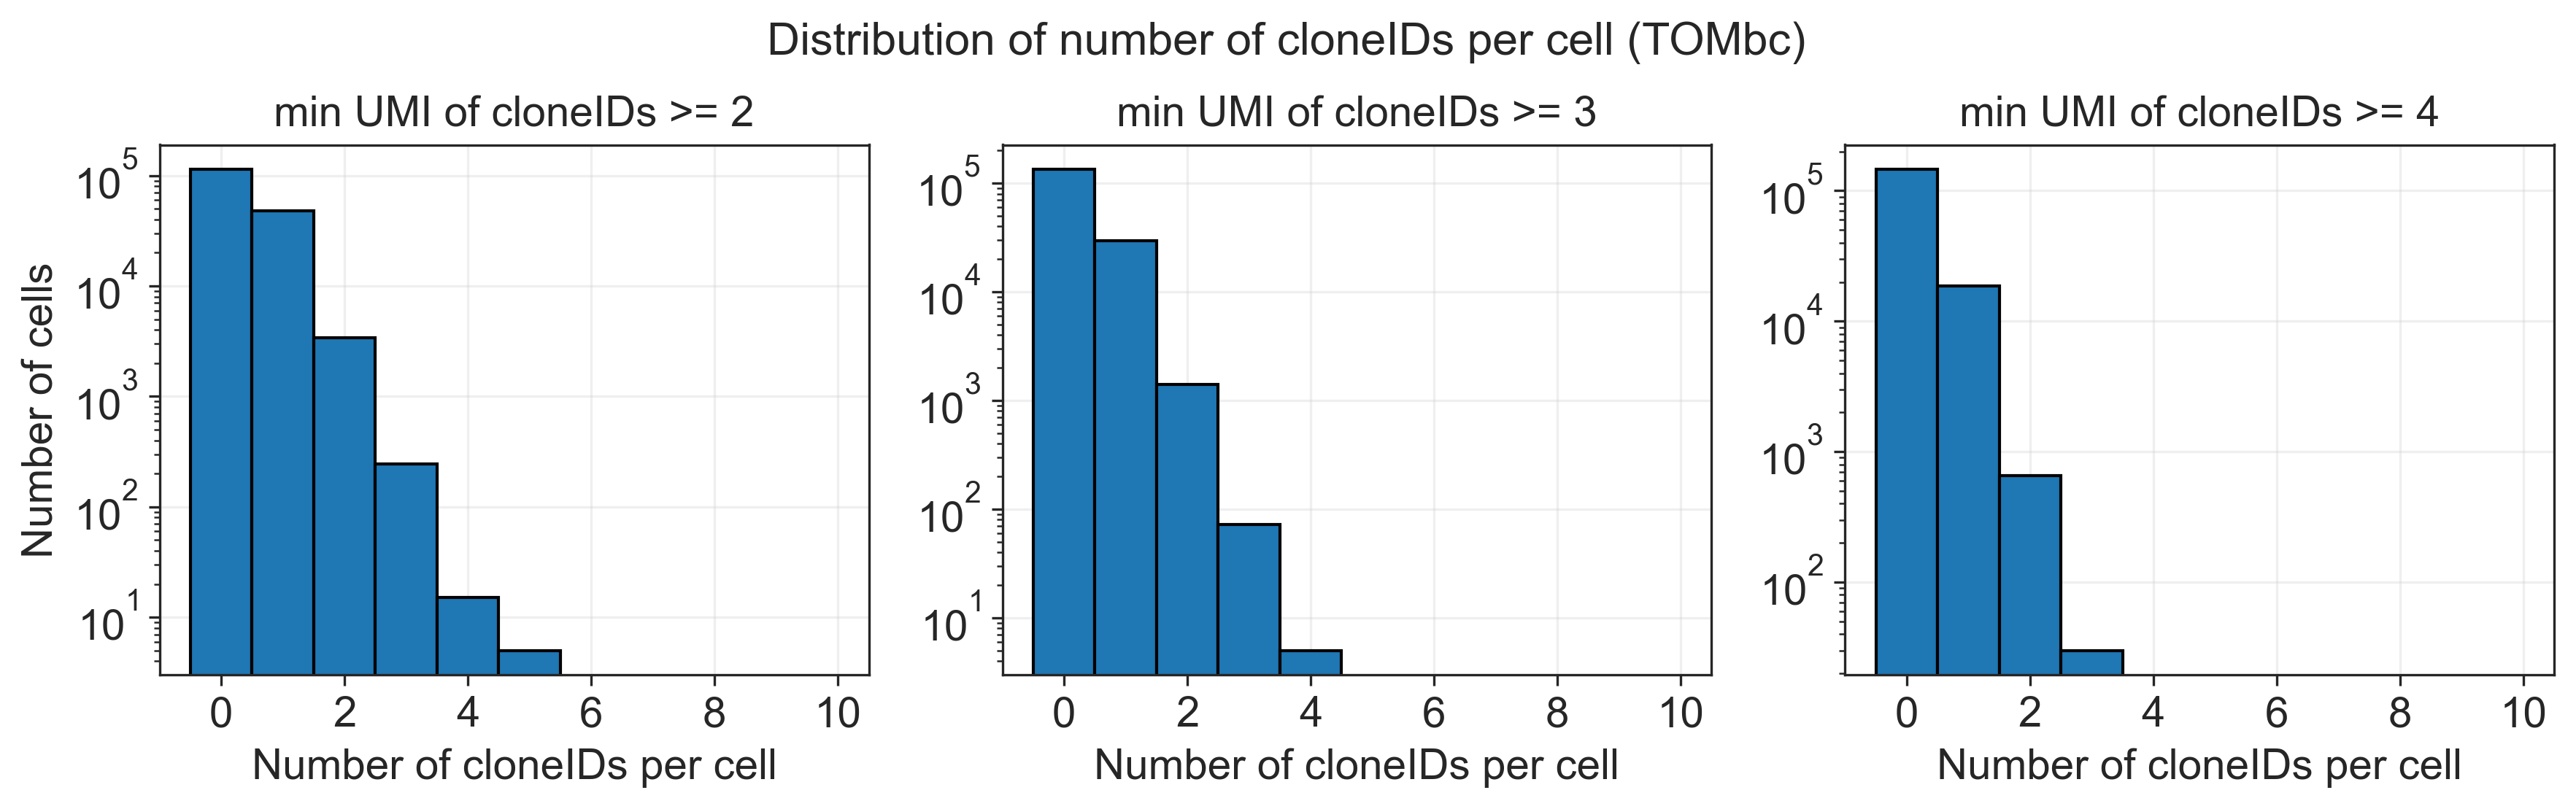

In [7]:
for FP in FPs:
    fig = draw_cloneID_QC(mdata[FP], FP)

/tmp/ipykernel_25663/3556839770.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=mdata[FP].obs.clone_id_multiplet, y=mdata["GEX"].obs.doublet_score, order=order,


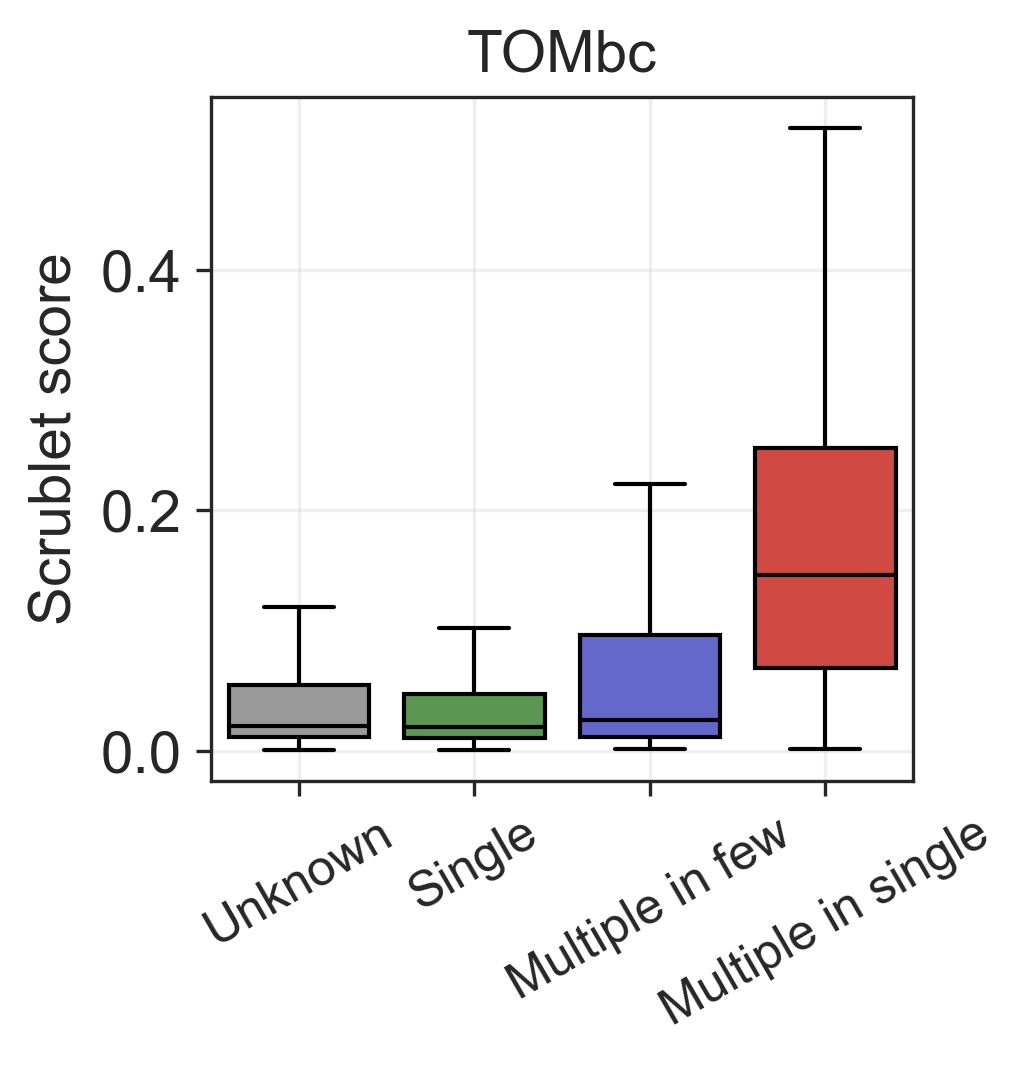

In [8]:
# Step 5: doublet detection via multiple clone ids per cell
# Unknown means that it is a barcoded cell without clonal marker
# Single means that it is a barcoded cell with only one clonal marker
# Multiple in few means multiple cells has with the barcode combo that this cell has.
# Multiple in single means Cell with barocde barcode but a multiple clonal barcodes with a unique combination.
min_cloneID_umi = 2

for FP in FPs:
    predict_doublets(mdata, FP, min_cloneID_umi=min_cloneID_umi)

    fig, ax = plt.subplots(figsize=(3, 3))
    order = ["Unknown", "Single", "Multiple in few", "Multiple in single"]
    sns.boxplot(x=mdata[FP].obs.clone_id_multiplet, y=mdata["GEX"].obs.doublet_score, order=order,
                showfliers=False, palette=colormap_boxplot_1, **black_borders_boxplot, linewidth=1)
    ax.tick_params(axis="x", labelrotation=30, labelsize=12)
    ax.set_ylabel("Scrublet score")
    ax.set_xlabel("")
    ax.grid(alpha=0.3)
    ax.set_title(FP)

In [9]:
if len(FPs) == 2:
    predict_doublets(mdata, FPs, min_cloneID_umi=min_cloneID_umi)

    fig, ax = plt.subplots(figsize=(3, 3))
    order = ["Unknown", "GFPbc", "TOMbc", "Multiple in few", "Multiple in single"]
    sns.boxplot(x=mdata.obs.clone_id_multiplet, y=mdata["GEX"].obs.doublet_score, order=order,
                showfliers=False, palette=colormap_boxplot_2, **black_borders_boxplot, linewidth=1)
    ax.tick_params(axis="x", labelrotation=30, labelsize=12)
    ax.set_ylabel("Scrublet score")
    ax.set_xlabel("")
    ax.grid(alpha=0.3)
    ax.set_title("Double injection")

In [10]:
mdata["GEX"].shape

(166315, 56692)

In [11]:
# THIS DOES NOT ADAPT TO SETTING THRESHOLD EARLIER!!!!
# NEED TO FIX!!!!!. 
#mdata["GEX"].obs["predicted_doublet"] = (mdata["GEX"].obs.doublet_score > 0.15).astype(str) # I ALREADY HAVE THIS????
print(f"Total num of cells: {len(mdata['GEX'])}")
if len(FPs) == 2:
    doublets = (
        (mdata["GEX"].obs.predicted_doublet == "True") |
        (mdata[FPs[0]].obs.clone_id_multiplet == "Multiple in single") |
        (mdata[FPs[1]].obs.clone_id_multiplet == "Multiple in single") |
        (mdata.obs.clone_id_multiplet == "Multiple in single")
    )
    print(f"Number of estimated doublets: {doublets.sum()} ({doublets.sum() / len(mdata['GEX']) * 100:.2f}%)")
else:
    doublets = (
        (mdata["GEX"].obs.predicted_doublet == "True") |
        (mdata[FPs[0]].obs.clone_id_multiplet == "Multiple in single") 
    )
    print(f"Number of estimated doublets: {doublets.sum()} ({doublets.sum() / len(mdata['GEX']) * 100:.2f}%)")

Total num of cells: 166315
Number of estimated doublets: 32340 (19.45%)


In [12]:
# Step 6: filtering out doublets
mdata = mdata[~doublets]
del mdata["GEX"].obs["predicted_doublet"]

In [13]:
mdata["GEX"].shape

(133975, 56692)

In [14]:
# Essentially what this does is that it creates a clones column that would seperate the two FPs by batch and also
# it sets an easier to read naming convention for the clones. 
batch = list(set(mdata["GEX"].obs.batch))[0]
print(batch)
for FP in FPs:
    mdata["GEX"].obs[f"{time[FP]}:clones"] = fast_clones(mdata[FP], min_cloneID_umi=min_cloneID_umi) # Name clone_nr or Unknown for all clones.
    for clone in mdata["GEX"].obs[f"{time[FP]}:clones"].value_counts()[mdata["GEX"].obs[f"{time[FP]}:clones"].value_counts() == 1].index:
        mdata["GEX"].obs[f"{time[FP]}:clones"][mdata["GEX"].obs[f"{time[FP]}:clones"] == clone] == "Unknown" # Set all that appear one time to Unknown
    mdata["GEX"].obs[f"{time[FP]}:clones"] = [
        "NA" if i == "Unknown" else batch + ":" + i for i in mdata["GEX"].obs[f"{time[FP]}:clones"]
    ]
    mdata["GEX"].obs[f"{time[FP]}:clones"] = mdata["GEX"].obs[f"{time[FP]}:clones"].astype("category")

injection33


/tmp/ipykernel_25663/689338001.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mdata["GEX"].obs[f"{time[FP]}:clones"] = fast_clones(mdata[FP], min_cloneID_umi=min_cloneID_umi) # Name clone_nr or Unknown for all clones.


In [15]:
mdata.update()
mdata.write_h5mu(f"{DATA_PATH}/anndatas_counts/{batch}.h5mu")
mdata["GEX"].write_h5ad(f"{DATA_PATH}/anndatas_counts/{batch}.h5ad")

/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/mudata/_core/mudata.py:1232: ImplicitModificationWarning: Setting element `.varm['GEX']` of view, initializing view as actual.
  attrm[mod] = mapping > 0
/home/felix/miniconda3/envs/new_sclitr/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs